In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
import torch.optim as optim

/kaggle/input/e-commerce-synthetic-dataset/ecommerce_synthetic_data.csv


In [2]:
training_data = pd.read_csv("/kaggle/input/e-commerce-synthetic-dataset/ecommerce_synthetic_data.csv")
training_data.head()

,ordered,past_spending,price,quantity,membership_flag,goods_type_clothing,goods_type_eletronics,goods_type_food,goods_type_furniture,goods_type_kichenware,goods_type_medicine,brand_tier_cheap,brand_tier_highend,brand_tier_popular
0,0,1023.73,75.934756,1,0,1,0,0,0,0,0,1,0,0
1,0,0.00,278.957661,2,0,0,1,0,0,0,0,0,1,0
2,0,1873.31,7.383762,5,0,1,0,0,0,0,0,0,1,0
3,0,592.82,72.419637,1,0,0,1,0,0,0,0,0,0,1
4,0,796.50,350.501563,1,1,0,0,0,1,0,0,0,0,1


In [3]:
class MaxWinRateParam(nn.Module):
    def __init__(self):
        super(MaxWinRateParam, self).__init__()
        self.hidden_layer = nn.Linear(12, 5)
        self.output_layer = nn.Linear(5, 1)
        self.sigmoid_activation = nn.Sigmoid()

    def forward(self, x):
        x = self.hidden_layer(x)
        x = self.output_layer(x)
        x = self.sigmoid_activation(x)
        return x


class BiasParam(nn.Module):
    def __init__(self):
        super(BiasParam, self).__init__()
        self.hidden_layer = nn.Linear(12, 5)
        self.relu_activation = nn.ReLU()
        self.output_layer = nn.Linear(5, 1)
        self.elu_activation = nn.ELU()

    def forward(self, x):
        x = self.hidden_layer(x)
        x = self.relu_activation(x)
        x = self.output_layer(x)
        x = self.elu_activation(x)
        return x


class SensitivityParam(nn.Module):
    def __init__(self):
        super(SensitivityParam, self).__init__()
        self.hidden_layer = nn.Linear(12, 5)
        self.relu_activation = nn.ReLU()
        self.output_layer = nn.Linear(5, 1)

    def forward(self, x):
        x = self.hidden_layer(x)
        x = self.relu_activation(x)
        x = self.output_layer(x)
        x = self.relu_activation(x)
        return torch.exp(x) - 1


class WinRateNetwork(nn.Module):
    def __init__(self):
        super(WinRateNetwork, self).__init__()
        self.max_win_rate = MaxWinRateParam()
        self.bias = BiasParam()
        self.sensitivity = SensitivityParam()

    def forward(self, features, price):
        mul_term = torch.mul(self.sensitivity(features), price)
        add_term = torch.add(self.bias(features), mul_term)
        return self.max_win_rate(features) / (1 + torch.exp(add_term))

In [4]:
train_features = training_data[[x for x in training_data.columns if x not in ["ordered", "price"]]]
train_features[["past_spending", "quantity"]] = StandardScaler().fit_transform(train_features[["past_spending", "quantity"]])

price_with_goods_type = pd.concat(
    [
        training_data["price"],
        pd.from_dummies(training_data[[x for x in training_data.columns if "goods_type" in x]], sep="_"),
    ], 
    axis=1,
)
train_prices = price_with_goods_type.groupby("goods")["price"].transform(
    lambda x: StandardScaler().fit_transform(x.values[:,np.newaxis]).ravel()
).values.reshape(-1,1)

price_with_goods_type.groupby("goods").mean().reset_index().round(2)

,goods,price
0,type_clothing,116.90
1,type_eletronics,160.34
2,type_food,39.98
3,type_furniture,237.82
4,type_kichenware,80.62
5,type_medicine,58.16


In [5]:
# convert pandas DataFrame (X) and numpy array (y) into PyTorch tensors
X_train = torch.tensor(train_features.values, dtype=torch.float32)
price_train = torch.tensor(train_prices, dtype=torch.float32)
y_train = torch.tensor(training_data["ordered"].values.reshape(-1,1), dtype=torch.float32)

# training parameters
n_epochs = 500
batch_size = 256
batches_per_epoch = len(X_train) // batch_size

model = WinRateNetwork()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

for epoch in range(n_epochs):
    if epoch % 100 == 0:
        print(f"Epoch: {epoch + 1}")
    for i in range(batches_per_epoch):
        # take a batch
        start = i * batch_size
        X_batch = X_train[start:start + batch_size]
        price_batch = price_train[start:start + batch_size]
        y_batch = y_train[start:start + batch_size]
        # forward pass
        y_pred = model(X_batch, price_batch)
        loss = criterion(y_pred, y_batch)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()

Epoch: 1
Epoch: 101
Epoch: 201
Epoch: 301
Epoch: 401


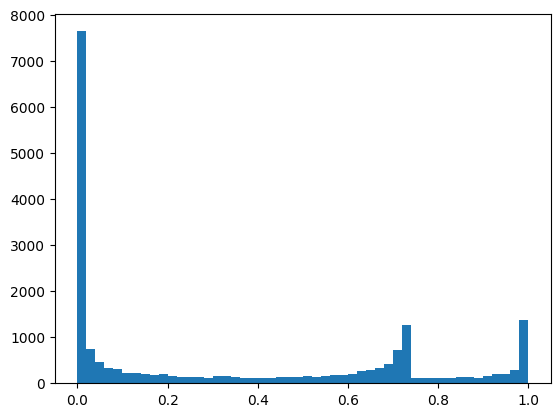

0.9632014481287836

In [6]:
pred = model(X_train, price_train).detach().numpy()
plt.hist(pred, bins=50)
plt.show()
roc_auc_score(y_train, pred)